In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out, _ = self.rnn(x.unsqueeze(1))
        return self.fc_layers(out[:, -1, :])

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x.unsqueeze(1))
        return self.fc_layers(out[:, -1, :])

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out, _ = self.gru(x.unsqueeze(1))
        return self.fc_layers(out[:, -1, :])

In [13]:

def prepare_data_time_series(df, target_col="Normalized_Efficiency", train_ratio=0.8):
    """
    Sorts the data by Date, drops unnecessary columns, 
    splits into train/test by index (80/20),
    and scales features with StandardScaler.
    """
    df = df.sort_values("Date").dropna(subset=[target_col]).reset_index(drop=True)
    df = df.drop(columns=["Date", "Station", "Energy Production (kWh)"], errors="ignore")

    cutoff = int(len(df) * train_ratio)
    train_df = df.iloc[:cutoff].copy()
    test_df  = df.iloc[cutoff:].copy()

    X_train = train_df.drop(columns=[target_col]).values
    y_train = train_df[target_col].values
    X_test  = test_df.drop(columns=[target_col]).values
    y_test  = test_df[target_col].values

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def compute_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    
    mask = (actual != 0)
    if np.any(mask):
        mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100
    else:
        mape = np.nan

    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape
    }


In [16]:

def train_dl_model(name, model_class, input_dim,
                   X_train, X_test, y_train, y_test,
                   epochs=100, batch_size=32):
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    y_test_t  = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1)

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t),
                              batch_size=batch_size, shuffle=True)

    model = model_class(input_dim)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

        scheduler.step()
        model.eval()
        with torch.no_grad():
            train_loss = criterion(model(X_train_t), y_train_t).item()
            test_loss  = criterion(model(X_test_t),  y_test_t).item()

        train_losses.append(train_loss)
        test_losses.append(test_loss)
    with torch.no_grad():
        preds  = model(X_test_t).squeeze().numpy()
        actual = y_test_t.squeeze().numpy()

    test_metrics = compute_metrics(actual, preds)

    metrics_df = pd.DataFrame({
        "epoch": range(1, epochs+1),
        "train_loss": train_losses,
        "test_loss": test_losses
    })
    pred_df = pd.DataFrame({"Actual": actual, "Predicted": preds})

    os.makedirs("../processed_data", exist_ok=True)
    metrics_path = f"../processed_data/{name.lower()}_metrics.csv"
    preds_path   = f"../processed_data/{name.lower()}_predictions.csv"
    metrics_df.to_csv(metrics_path, index=False)
    pred_df.to_csv(preds_path, index=False)

    return metrics_path, preds_path, train_losses, test_losses, test_metrics

In [17]:

def plot_metrics_bar_chart(metrics_df, title="Comparison of DL Models"):

    metric_cols = ["MSE", "RMSE", "MAE", "MAPE"]
    plot_df = metrics_df.melt(
        id_vars="Model",
        value_vars=metric_cols,
        var_name="Metric",
        value_name="Value"
    )
    
    plt.figure(figsize=(10, 5))
    import seaborn as sns
    sns.barplot(data=plot_df, x="Model", y="Value", hue="Metric")
    plt.title(title)
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()

    os.makedirs("../visualizations", exist_ok=True)
    outpath = f"../visualizations/dl_models_metrics_comparison.png"
    plt.savefig(outpath)
    plt.show()
    plt.close()

    print(f"Bar chart saved to: {outpath}")

Training stl_rnn ...
  -> Done. Metrics saved to: ../processed_data/stl_rnn_metrics.csv, Predictions: ../processed_data/stl_rnn_predictions.csv

Training hp_rnn ...
  -> Done. Metrics saved to: ../processed_data/hp_rnn_metrics.csv, Predictions: ../processed_data/hp_rnn_predictions.csv

Training stl_lstm ...
  -> Done. Metrics saved to: ../processed_data/stl_lstm_metrics.csv, Predictions: ../processed_data/stl_lstm_predictions.csv

Training hp_lstm ...
  -> Done. Metrics saved to: ../processed_data/hp_lstm_metrics.csv, Predictions: ../processed_data/hp_lstm_predictions.csv

Training stl_gru ...
  -> Done. Metrics saved to: ../processed_data/stl_gru_metrics.csv, Predictions: ../processed_data/stl_gru_predictions.csv

Training hp_gru ...
  -> Done. Metrics saved to: ../processed_data/hp_gru_metrics.csv, Predictions: ../processed_data/hp_gru_predictions.csv

=== Final Test Metrics for Each Model ===
      Model           MSE        RMSE        MAE          MAPE
0   stl_rnn  22462.472656  1

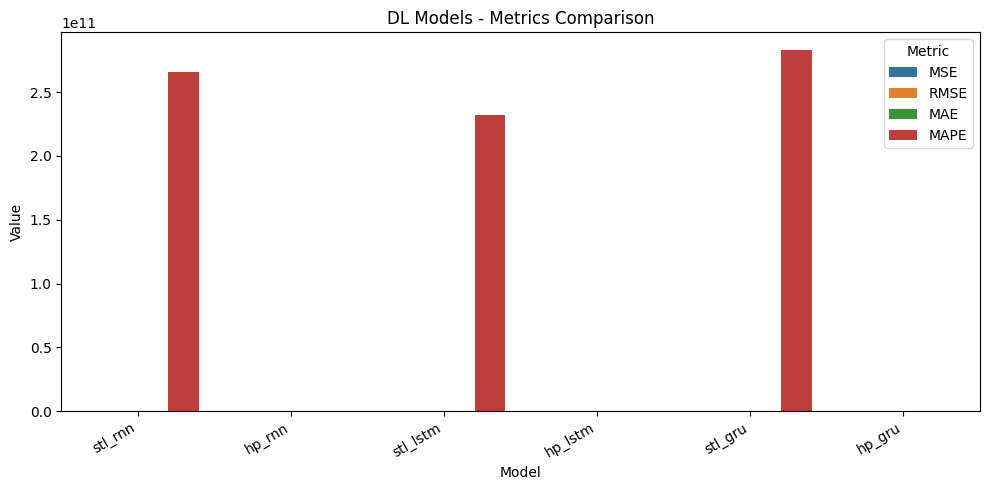

Bar chart saved to: ../visualizations/dl_models_metrics_comparison.png
All done!


In [18]:

stl_path = "../processed_data/STL/stl_energy_production_with_engineered_features.csv"
hp_path  = "../processed_data/HP/hp_energy_production_with_engineered_features.csv"
stl_df = pd.read_csv(stl_path)
hp_df  = pd.read_csv(hp_path)

stl_X_train, stl_X_test, stl_y_train, stl_y_test = prepare_data_time_series(stl_df)
hp_X_train,  hp_X_test,  hp_y_train,  hp_y_test  = prepare_data_time_series(hp_df)

stl_input_dim = stl_X_train.shape[1]
hp_input_dim  = hp_X_train.shape[1]

dl_models = {
    "stl_rnn":  (RNNModel,  stl_input_dim, stl_X_train, stl_X_test, stl_y_train, stl_y_test),
    "hp_rnn":   (RNNModel,  hp_input_dim,  hp_X_train,  hp_X_test,  hp_y_train,  hp_y_test),
    "stl_lstm": (LSTMModel, stl_input_dim, stl_X_train, stl_X_test, stl_y_train, stl_y_test),
    "hp_lstm":  (LSTMModel, hp_input_dim,  hp_X_train,  hp_X_test,  hp_y_train,  hp_y_test),
    "stl_gru":  (GRUModel,  stl_input_dim, stl_X_train, stl_X_test, stl_y_train, stl_y_test),
    "hp_gru":   (GRUModel,  hp_input_dim,  hp_X_train,  hp_X_test,  hp_y_train,  hp_y_test),
}

all_metrics = [] 

for name, (model_cls, dim, Xtr, Xte, ytr, yte) in dl_models.items():
    print(f"Training {name} ...")
    metrics_path, preds_path, train_losses, test_losses, test_metrics = train_dl_model(
        name, model_cls, dim, Xtr, Xte, ytr, yte,
        epochs=100, batch_size=32
    )
    row = {"Model": name}
    row.update(test_metrics)
    all_metrics.append(row)
    print(f"  -> Done. Metrics saved to: {metrics_path}, Predictions: {preds_path}\n")

metrics_df = pd.DataFrame(all_metrics)
print("=== Final Test Metrics for Each Model ===")
print(metrics_df)

plot_metrics_bar_chart(metrics_df, title="DL Models - Metrics Comparison")

print("All done!")

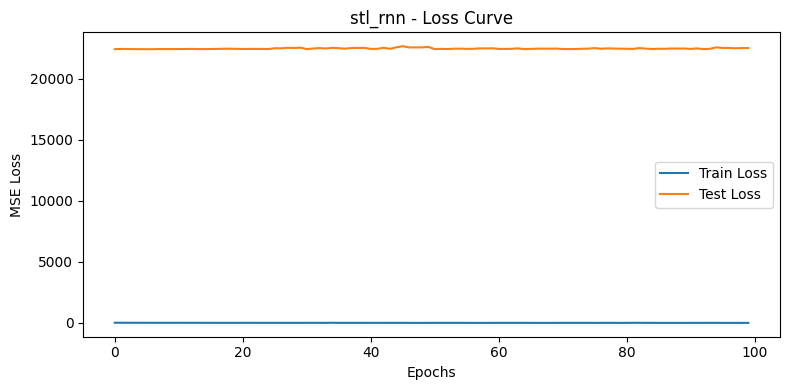

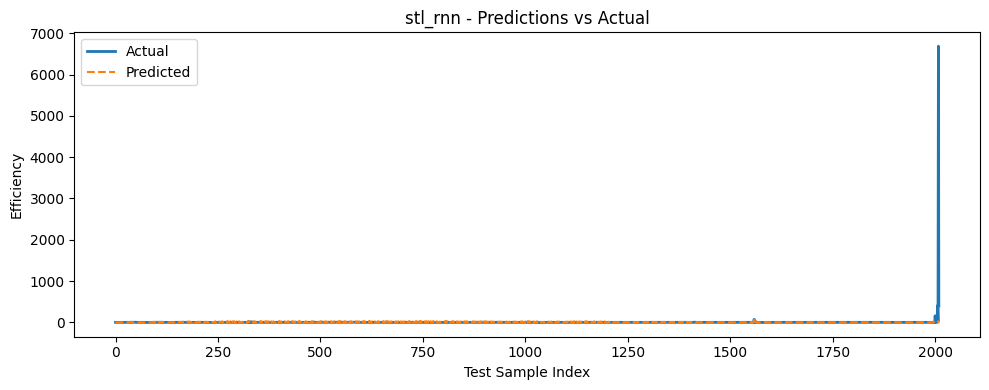

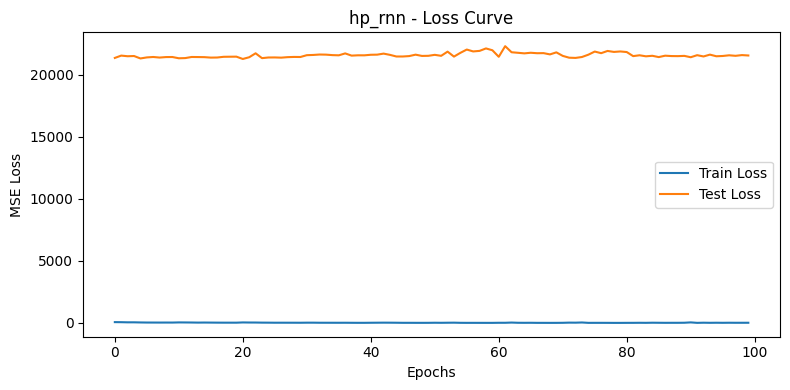

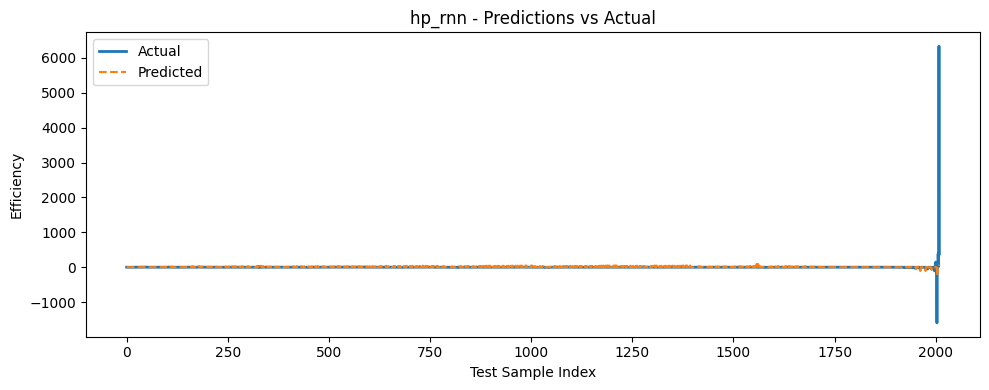

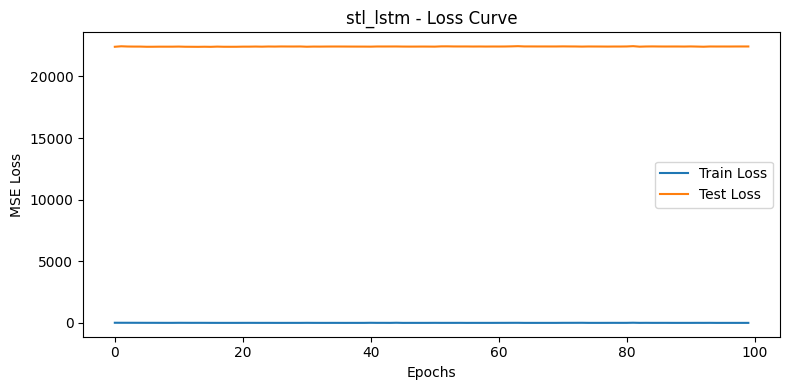

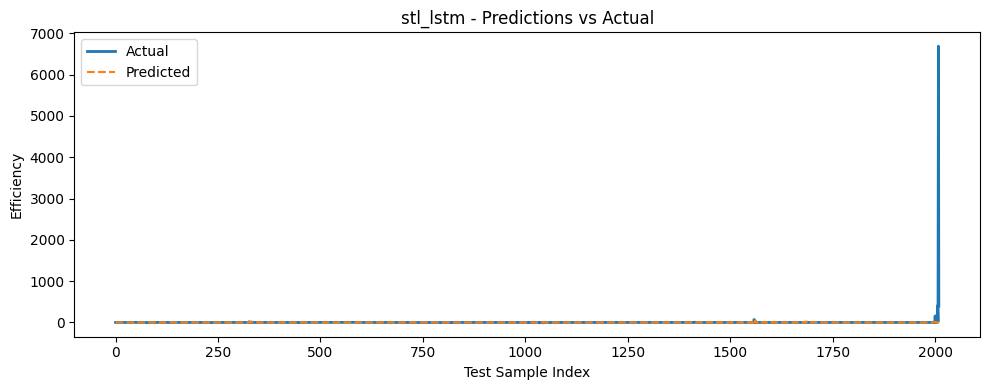

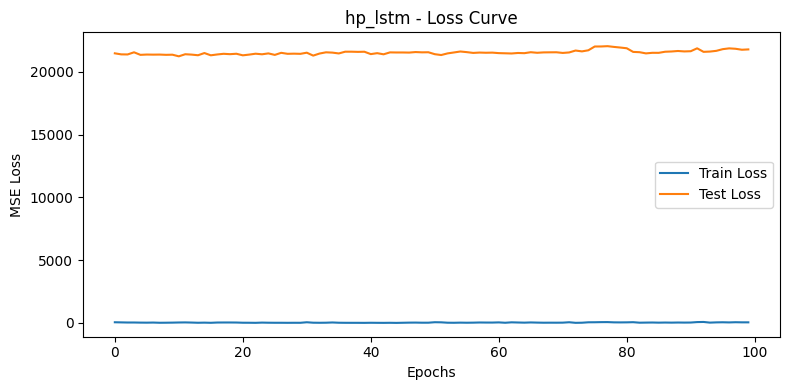

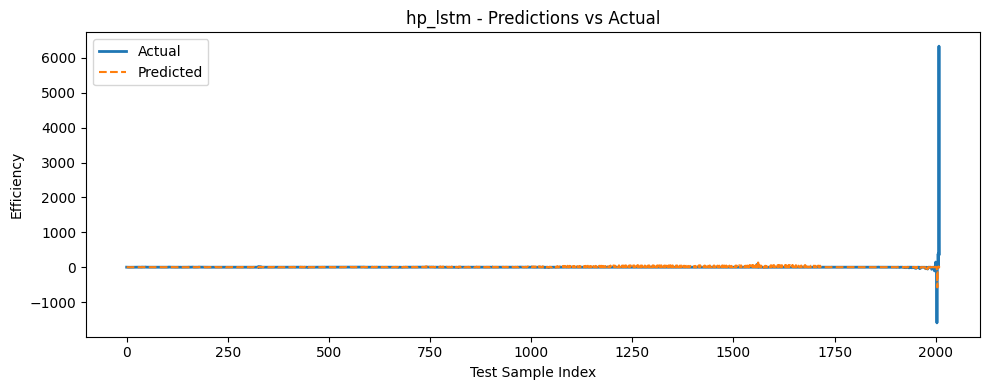

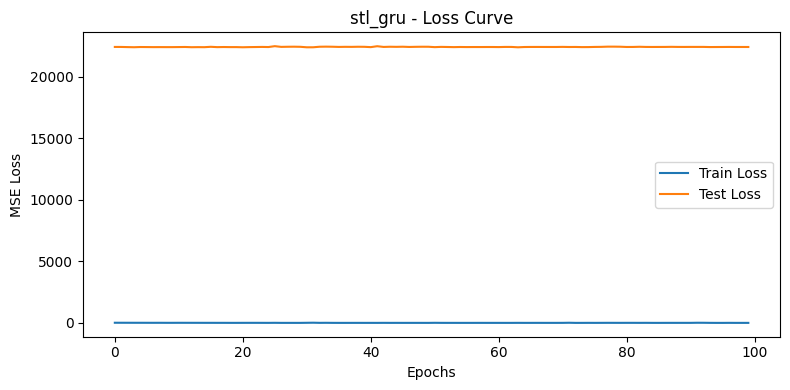

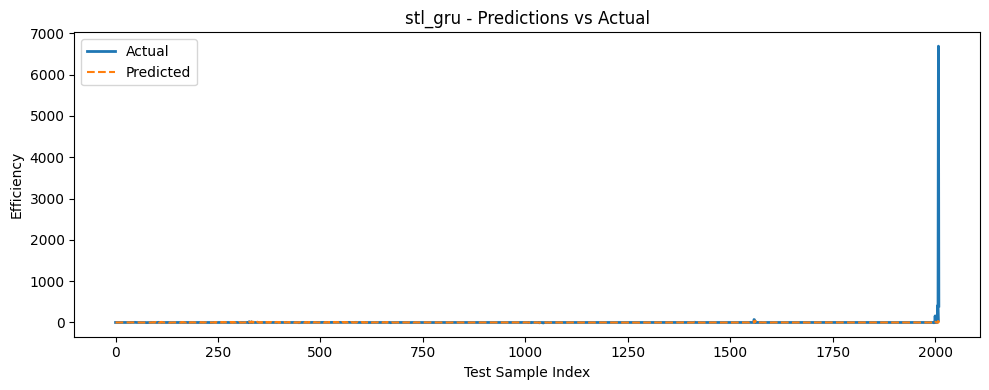

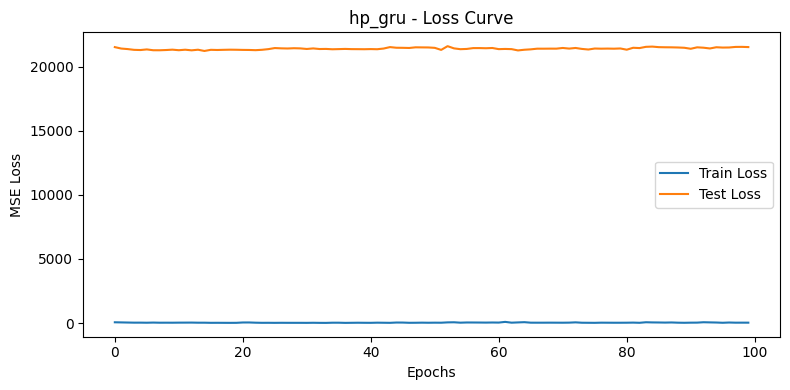

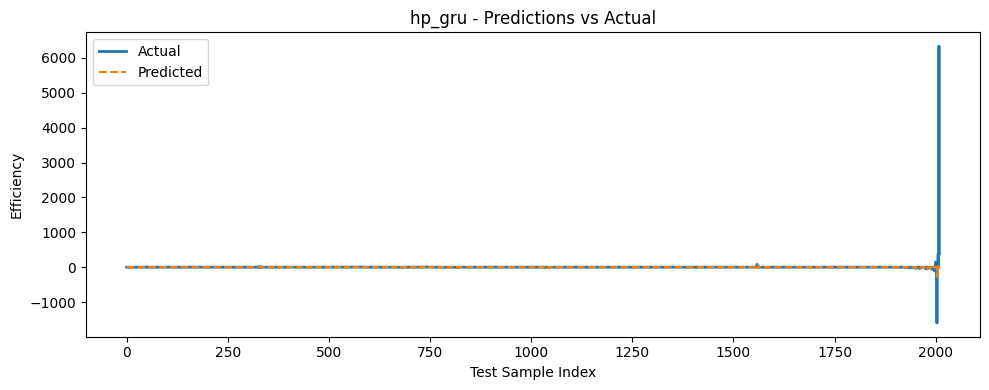

(['../visualizations/stl_rnn_loss_curve.png',
  '../visualizations/hp_rnn_loss_curve.png',
  '../visualizations/stl_lstm_loss_curve.png',
  '../visualizations/hp_lstm_loss_curve.png',
  '../visualizations/stl_gru_loss_curve.png',
  '../visualizations/hp_gru_loss_curve.png'],
 ['../visualizations/stl_rnn_pred_vs_actual.png',
  '../visualizations/hp_rnn_pred_vs_actual.png',
  '../visualizations/stl_lstm_pred_vs_actual.png',
  '../visualizations/hp_lstm_pred_vs_actual.png',
  '../visualizations/stl_gru_pred_vs_actual.png',
  '../visualizations/hp_gru_pred_vs_actual.png'])

In [5]:
import matplotlib.pyplot as plt
import os

def plot_loss_curve(train_loss, test_loss, model_name):
    plt.figure(figsize=(8, 4))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(test_loss, label='Test Loss')
    plt.title(f"{model_name} - Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.tight_layout()
    filename = f"../visualizations/{model_name.lower()}_loss_curve.png"
    plt.savefig(filename)
    plt.show()
    plt.close()
    return filename


def plot_pred_vs_actual(pred_csv_path, model_name):
    df = pd.read_csv(pred_csv_path)
    plt.figure(figsize=(10, 4))
    plt.plot(df["Actual"], label="Actual", linewidth=2)
    plt.plot(df["Predicted"], label="Predicted", linestyle="--")
    plt.title(f"{model_name} - Predictions vs Actual")
    plt.xlabel("Test Sample Index")
    plt.ylabel("Efficiency")
    plt.legend()
    plt.tight_layout()
    filename = f"../visualizations/{model_name.lower()}_pred_vs_actual.png"
    plt.savefig(filename)
    plt.show()
    plt.close()
    return filename

loss_plot_paths = []
pred_plot_paths = []

for model_name in results.keys():
    metrics_path = f"../processed_data/{model_name.lower()}_metrics.csv"
    preds_path = f"../processed_data/{model_name.lower()}_predictions.csv"

    if os.path.exists(metrics_path) and os.path.exists(preds_path):
        metrics = pd.read_csv(metrics_path)
        loss_path = plot_loss_curve(metrics["train_loss"], metrics["test_loss"], model_name)
        pred_path = plot_pred_vs_actual(preds_path, model_name)
        loss_plot_paths.append(loss_path)
        pred_plot_paths.append(pred_path)

loss_plot_paths, pred_plot_paths
